# Import packages

In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from common import *

# 1. Load dataset

In [2]:
train_data = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Preprocessing

## 1) Generate `Time`

In [3]:
%%time
train_data = generate_full_timestamp(train_data)

CPU times: user 5.28 s, sys: 158 ms, total: 5.44 s
Wall time: 3.45 s


## 2) Imputing

In [4]:
train_data = impute_data(train_data)

Number of Nan values: 0


## 3) Feature engineering

In [8]:
train_data = preprocess(train_data)

In [9]:
train_data.drop(columns=['Day', 'Tmstamp'], inplace=True)

In [10]:
train_data.head()

,TurbID,Wspd,Wdir,Etmp,Itmp,Ndir,Pab1,Pab2,Pab3,Prtv,Patv,Time,X,Y,Time_cos,Time_sin,Day_cos,Day_sin,Etmp_abs,Wdir_adj,Wdir_cos,Wdir_sin,Ndir_cos,Ndir_sin,Wspd_cos,Wspd_sin,RPM,Wspd_cube,P_max
0,1,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,1,3349.8515,5939.23193,0.999048,0.043619,0.999852,0.017213,273.88,21.93,0.927641,0.373474,0.899405,0.437116,6.155045,-0.429323,16.034441,233.181313,0.857621
1,1,6.17,-3.99,30.73,41.80,25.92,1.0,1.0,1.0,-0.25,494.66,2,3349.8515,5939.23193,0.999048,0.043619,0.999852,0.017213,273.88,21.93,0.927641,0.373474,0.899405,0.437116,6.155045,-0.429323,16.034441,233.181313,0.857621
2,1,6.27,-2.18,30.60,41.63,20.91,1.0,1.0,1.0,-0.24,509.76,3,3349.8515,5939.23193,0.996195,0.087156,0.999852,0.017213,273.75,18.73,0.947042,0.321109,0.934142,0.356901,6.265462,-0.238505,16.322087,245.957079,0.900427
3,1,6.42,-0.73,30.52,41.52,20.91,1.0,1.0,1.0,-0.26,542.53,4,3349.8515,5939.23193,0.991445,0.130526,0.999852,0.017213,273.67,20.18,0.938613,0.344971,0.934142,0.356901,6.419479,-0.081794,16.723314,264.544863,0.966892
4,1,6.25,0.89,30.49,41.38,20.91,1.0,1.0,1.0,-0.23,509.36,5,3349.8515,5939.23193,0.984808,0.173648,0.999852,0.017213,273.64,21.80,0.928486,0.371368,0.934142,0.356901,6.249246,0.097080,16.279842,244.052275,0.892196


## 3) Split data

In [11]:
IN_SEQ_LEN  = 5*144
OUT_SEQ_LEN = 2*144
STRIDE      = 1*144
SHUFFLE     = False
TEST_SIZE   = 0.2

In [12]:
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(train_data, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)
train_y = train_y[:, :, -2]
val_y   = val_y[:, :, -2]
print("y:", train_y.shape, val_y.shape)

100%|██████████| 134/134 [00:15<00:00,  8.90it/s]


Train data(X, y)     : (19832, 720, 28) (19832, 288, 28)
Validation data(X, y): (4958, 720, 28) (4958, 288, 28)
Test data(X)         : (134, 720, 28)
y: (19832, 288) (4958, 288)


# 3. Modeling

In [13]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU

tf.keras.utils.set_random_seed(RANDOM_STATE)
for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-12 13:11:18.103521: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 13:11:18.106693: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 13:11:18.106854: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [14]:
model = Sequential([
    GRU(256, input_shape=train_x[0].shape),
    Dense(516, activation='relu'),
    Dense(288, activation='relu')
])
optimizer = tf.optimizers.RMSprop(0.001)
model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

2022-07-12 13:11:18.661525: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-12 13:11:18.662233: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 13:11:18.662394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-12 13:11:18.662494: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# 4. Training

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

model.fit(train_x, train_y, validation_data=(val_x, val_y), epochs=1000, batch_size=128, callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]);

Epoch 1/1000


2022-07-12 13:11:23.832723: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101


  3/155 [..............................] - ETA: 5s - loss: 8.9819 - mae: 1.5634   

2022-07-12 13:11:24.318222: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


155/155 [==============================] - 9s 45ms/step - loss: 6.3141 - mae: 1.4732 - val_loss: 4.8523 - val_mae: 1.2697
Epoch 2/1000
155/155 [==============================] - 7s 42ms/step - loss: 5.9640 - mae: 1.4244 - val_loss: 4.8110 - val_mae: 1.2360
Epoch 3/1000
155/155 [==============================] - 6s 42ms/step - loss: 5.8442 - mae: 1.4068 - val_loss: 4.8420 - val_mae: 1.2266
Epoch 4/1000
155/155 [==============================] - 6s 42ms/step - loss: 5.8125 - mae: 1.4014 - val_loss: 4.9603 - val_mae: 1.3928
Epoch 5/1000
155/155 [==============================] - 7s 42ms/step - loss: 5.7198 - mae: 1.3902 - val_loss: 5.3521 - val_mae: 1.5708
Epoch 6/1000
155/155 [==============================] - 7s 42ms/step - loss: 5.7585 - mae: 1.3954 - val_loss: 5.1431 - val_mae: 1.4600
Epoch 7/1000
155/155 [==============================] - 6s 42ms/step - loss: 5.6929 - mae: 1.3860 - val_loss: 4.7764 - val_mae: 1.1593
Epoch 8/1000
155/155 [==============================] - 6s 42ms/step

# 5. Check validation set

In [17]:
y_true = val_y
y_pred = model.predict(val_x)

155/155 [==============================] - 2s 13ms/step


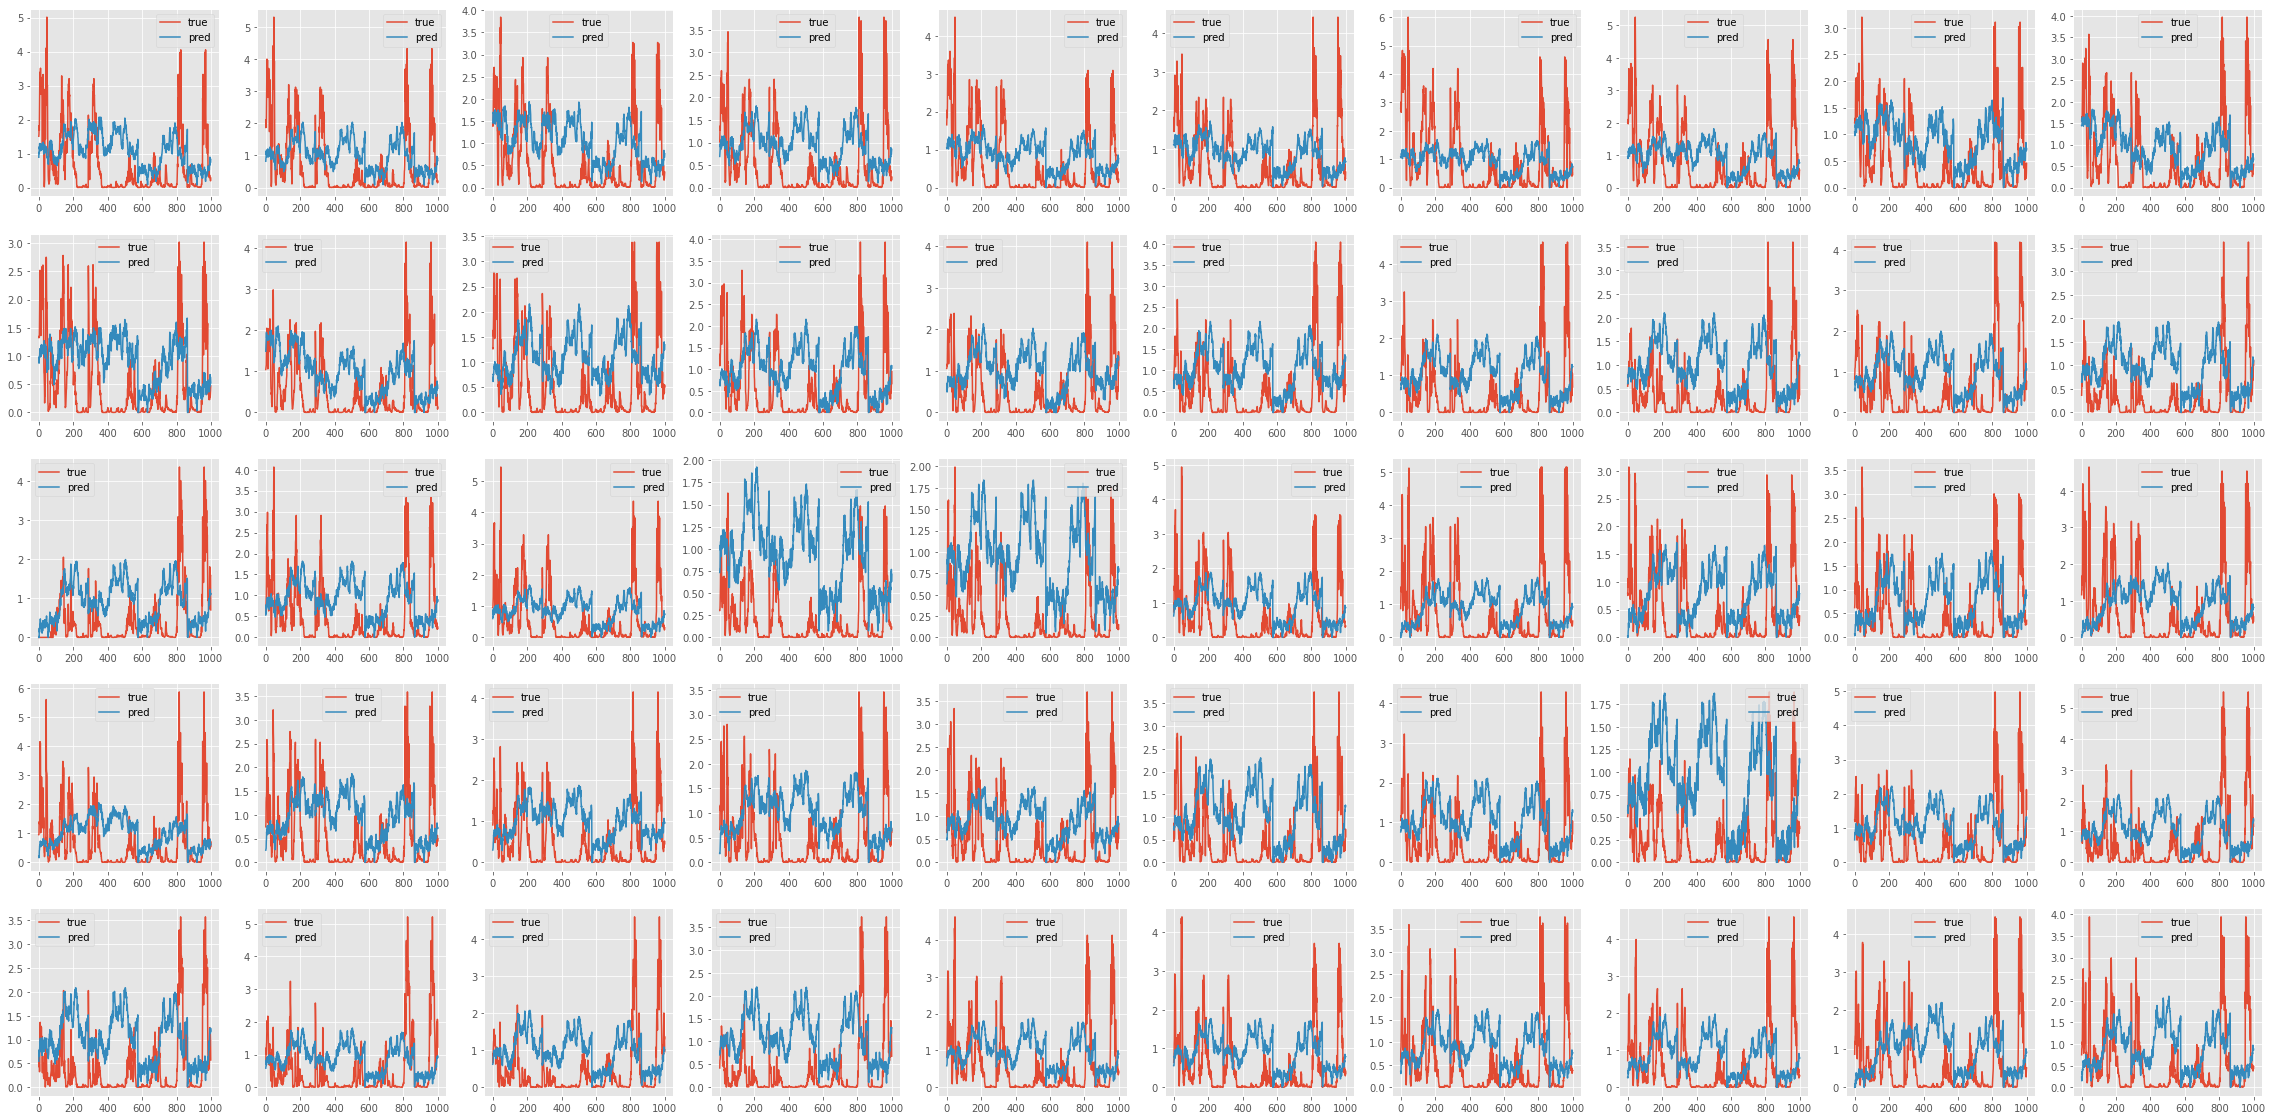

In [27]:
plt.style.use('ggplot')

fig, axes = plt.subplots(5, 10, figsize=(40, 20))
for i, ax in enumerate(axes.flatten()):  # i: turbID
    y_t = y_true[37*i:37*(i+1)].reshape(-1)[:1000]
    y_p = y_pred[37*i:37*(i+1)].reshape(-1)[:1000]
    ax.plot(y_t, label='true')
    ax.plot(y_p, label='pred')
    ax.legend()

# 6. Generate submission

In [28]:
sample_submission['Patv'] = model.predict(test_x).reshape(-1)
sample_submission.to_csv(join(PATH.output, "proposed8.csv"), index=False)

5/5 [==============================] - 0s 14ms/step
